In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict
from random import randint

In [2]:
'''                      ##           Constants are here            ##                      '''

PATH_TO_GRAPH: str = "./Gowalla_edges.txt"
PATH_TO_CHECKINS: str = "./Gowalla_totalCheckins.txt"
NODES_TO_PROCESS: int = 250

In [3]:
%%time
'''                      ##           Loading of friendship graph adjacency matrix is incoming            ##                      '''

def load_graph(path_to_data: str, nodes_to_process: int) -> np.ndarray:
    m: np.ndarray = np.zeros(shape=(nodes_to_process, nodes_to_process), dtype=float)

    with open(path_to_data, "r") as file:
        for line in file:
            if line.strip():
                i: int
                j: int
                i, j = map(int, line.split())
                if i < nodes_to_process and j < nodes_to_process:
                    m[i, j], m[j, i] = 1, 1
    return m

graph: np.ndarray = load_graph(PATH_TO_GRAPH, NODES_TO_PROCESS)
print(graph,'\n\n')

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]] 


Wall time: 1.07 s


In [4]:
%%time
'''                      ##           Prepairing similarities matrix from friendship matrix            ##                      '''

def calculate_similarities(x: np.ndarray) -> np.ndarray:
    s: np.ndarray = np.zeros(x.shape)

    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            s[i, j] = -1 * (x[i] - x[j]).T.dot(x[i] - x[j])

    min_val: int = np.median(s)

    for i in range(x.shape[0]):
        s[i, i] = min_val
    return s

init_sim: np.ndarray = calculate_similarities(graph)
print(init_sim,'\n\n')

[[ -10. -232. -217. ... -245. -249. -243.]
 [-232.  -10.  -33. ...  -19.  -19.  -25.]
 [-217.  -33.  -10. ...  -30.  -34.  -38.]
 ...
 [-245.  -19.  -30. ...  -10.   -6.  -12.]
 [-249.  -19.  -34. ...   -6.  -10.   -8.]
 [-243.  -25.  -38. ...  -12.   -8.  -10.]] 


Wall time: 215 ms


In [5]:
%%time
'''                      ##           Affinity Propagation algorithm is here uf           ##                      '''

def do_affinity_propagation(s: np.ndarray, max_iter: int, damping: float):
    n: int = s.shape[0]
    r: np.ndarray = np.zeros(s.shape)
    a: np.ndarray = np.zeros(s.shape)

    for step in range(max_iter):
        r_old: np.ndarray = r.copy()
        a_old: np.ndarray = a.copy()

        # Calc responsibilities
        for i in range(n):
            for k in range(n):
                t = a[i] + s[i]
                t[k] = -np.inf
                r[i, k] = s[i, k] - np.max(t)

        # Calc availabilities
        for i in range(n):
            for k in range(n):
                if i != k:
                    r_i_k, r[i, k] = r[i, k], -np.inf
                    r_k_k, r[k, k] = r[k, k], -np.inf
                    a[i, k] = min(0, r_k_k + np.sum(np.maximum(r[k], np.zeros_like(r[k]))))
                    r[i, k] = r_i_k
                    r[k, k] = r_k_k

        for k in range(n):
            r_k_k, r[k, k] = r[k, k], -np.inf
            a[k, k] = min(0, np.sum(np.maximum(r[k], np.zeros_like(r[k]))))
            r[k, k] = r_k_k

        # Exponential smoothing incoming
        if step > 0:
            r = damping * r_old + (1 - damping) * r
            a = damping * a_old + (1 - damping) * a

    return r, a


class MyAffinityPropagation:
    __r: np.ndarray
    __a: np.ndarray
    max_iter: int
    damping: float

    def __init__(self, damping: float = 0.8, max_iter: int = 100):
        self.damping = damping
        self.max_iter = max_iter
        self.__r = np.empty(0)
        self.__a = np.empty(0)

    def fit(self, s: np.ndarray):
        assert len(s.shape) == 2 and s.shape[0] == s.shape[1]
        self.__r, self.__a = do_affinity_propagation(s, self.max_iter, self.damping)

        return self

    @property
    def labels(self) -> List[int]:
        t: np.ndarray = self.__r + self.__a

        return [np.argmax(t[i]) for i in range(t.shape[0])]


exemplars: List[int] = MyAffinityPropagation(damping=0.9, max_iter=200).fit(init_sim).labels
print(exemplars, '\n\n')

[0, 1, 2, 3, 39, 5, 167, 150, 39, 10, 11, 10, 39, 39, 70, 15, 8, 120, 223, 197, 223, 21, 22, 39, 39, 91, 231, 39, 64, 150, 227, 31, 120, 39, 126, 39, 39, 70, 39, 47, 40, 41, 161, 91, 166, 8, 39, 39, 39, 248, 39, 64, 52, 53, 166, 12, 12, 39, 24, 12, 8, 70, 161, 63, 39, 24, 66, 120, 68, 39, 39, 39, 39, 91, 39, 248, 223, 39, 197, 8, 13, 183, 82, 223, 39, 8, 113, 39, 88, 89, 223, 39, 126, 69, 206, 126, 91, 97, 98, 99, 150, 120, 39, 39, 100, 39, 157, 199, 157, 233, 39, 111, 125, 39, 223, 39, 116, 159, 39, 70, 39, 227, 39, 126, 124, 230, 39, 46, 39, 39, 159, 120, 64, 135, 120, 133, 71, 197, 138, 139, 227, 77, 39, 143, 23, 150, 39, 39, 233, 122, 39, 227, 39, 203, 27, 77, 233, 39, 91, 39, 39, 230, 69, 122, 39, 165, 39, 39, 159, 159, 69, 39, 172, 12, 12, 39, 39, 12, 178, 39, 77, 8, 182, 39, 184, 154, 69, 8, 188, 12, 190, 235, 39, 64, 248, 110, 12, 39, 120, 39, 243, 39, 69, 153, 204, 159, 39, 207, 39, 209, 12, 211, 212, 13, 39, 39, 120, 217, 120, 91, 220, 221, 87, 39, 39, 39, 8, 39, 248, 227, 16

In [6]:
clusters: Dict[int, List[int]] = {x: [] for x in set(exemplars)}
for i in range(len(exemplars)):
    clusters[exemplars[i]].append(i)

clusters

{0: [0],
 1: [1],
 2: [2],
 3: [3],
 5: [5],
 8: [16, 45, 60, 79, 85, 181, 187, 226, 236, 242, 249],
 10: [9, 11],
 11: [10],
 12: [55, 56, 59, 173, 174, 177, 189, 196, 210, 239],
 13: [80, 213],
 15: [15],
 21: [21],
 22: [22],
 23: [144],
 24: [58, 65],
 27: [154],
 31: [31],
 36: [245],
 39: [4,
  8,
  12,
  13,
  23,
  24,
  27,
  33,
  35,
  36,
  38,
  46,
  47,
  48,
  50,
  57,
  64,
  69,
  70,
  71,
  72,
  74,
  77,
  84,
  87,
  91,
  102,
  103,
  105,
  110,
  113,
  115,
  118,
  120,
  122,
  126,
  128,
  129,
  142,
  146,
  147,
  150,
  152,
  157,
  159,
  160,
  164,
  166,
  167,
  171,
  175,
  176,
  179,
  183,
  192,
  197,
  199,
  201,
  206,
  208,
  214,
  215,
  223,
  224,
  225,
  227,
  231,
  235,
  240,
  246,
  248],
 40: [40],
 41: [41],
 46: [127],
 47: [39],
 52: [52],
 53: [53],
 63: [63],
 64: [28, 51, 132, 193],
 66: [66],
 68: [68],
 69: [93, 162, 170, 186, 202, 243, 247],
 70: [14, 37, 61, 119],
 71: [136],
 77: [141, 155, 180, 233],
 82: [

In [7]:
cluster_sizes = np.array([len(x) for x in clusters.values()])

print(f"Total num of clusters is: {len(set(exemplars))}\n" + 
    f"Min size of cluster: {np.min(cluster_sizes)}\n" + 
    f"Average size of cluster: {np.average(cluster_sizes)}\n" + 
    f"Median size of cluster: {np.median(cluster_sizes)}\n" + 
    f"Max size of cluster: {np.max(cluster_sizes)}")
    

Total num of clusters is: 93
Min size of cluster: 1
Average size of cluster: 2.6881720430107525
Median size of cluster: 1.0
Max size of cluster: 71


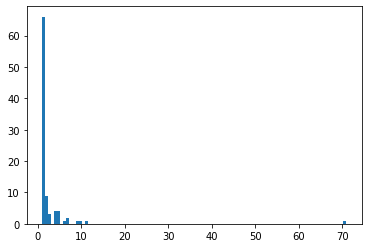

,user_id,place_id
0,0,22847
1,0,420315
2,0,316637
3,0,16516
4,0,5535878
...,...,...
6442887,196578,906885
6442888,196578,965121
6442889,196578,1174322
6442890,196585,471724


In [8]:
'''                      ##           The distribution of clusters by their's sizes            ##                      '''

%matplotlib inline
plt.hist(list(map(len, clusters.values())), bins=100)
plt.show()

df: pd.DataFrame = pd \
    .read_table(PATH_TO_CHECKINS, header=None, delim_whitespace=True) \
    .drop([1, 2, 3], axis=1) \
    .rename(columns={0: 'user_id', 4: 'place_id'})

df

In [9]:
%%time
'''                      ##           Estimates accuracy over the checkins data frame            ##                      '''

def estimate_accuracy(clusters: Dict[int, List[int]],
                      suggestion_size: int,
                      df: pd.DataFrame,
                      df_elem_col: str,
                      df_wish_col: str,
                      iters_count: int = 10) -> float:

    result = 0
    for i in range(iters_count):
        iter_results: List[float] = []

        for exemplar, cluster in clusters.items():
            if len(cluster) < 2:
                iter_results.append(0)
                continue
            cluster: List[int]
            places: Dict[int, int] = {}
            cluster = cluster.copy()
            secret_user: int = cluster.pop(randint(0, len(cluster) - 1))

            for user_id in cluster:
                for place_id in df[df[df_elem_col] == user_id][df_wish_col]:
                    places[place_id] = places.get(place_id, 0) + 1

            top = sorted(places)[:suggestion_size]
            secret_places = df[df[df_elem_col] == secret_user][df_wish_col]
            hits_count = sum(int(p in secret_places) for p in top)
            iter_results.append(hits_count / suggestion_size)
        result += sum(iter_results) / len(iter_results)
    return result / iters_count

accuracy = estimate_accuracy(
    clusters,
    suggestion_size=10,
    df = df,
    df_elem_col='user_id',
    df_wish_col='place_id',
    iters_count=20)

print(f"Prediction accuracy is: {accuracy * 100}%"+'\n\n')

Prediction accuracy is: 0.23655913978494628%


Wall time: 33.1 s
